| Library/module | Description   |
|------|------|
|   np  | Library for scientific computing in Python|
|   pandas  | helps in manipulation and storage of tabular data, provides data analysis and manipulation tools|
|   os  | helps us interact with system's operating system|
|   scipy.io  | to access our mat files|
|   tqdm  | instant progress bar/meter while using looping statements|
|   matplotlib.pyplot  | for data visualisation|
|   gc  | garbage collecter interface|
|   torch vision | contains datasets, models and transformation operations for computer vision|
|   torch nn | module to create and train Neural Networks |

In [ ]:
import numpy as np 
import pandas as pd 
import os 
import scipy.io 
from skimage.transform import resize
from tqdm import tqdm 
import matplotlib.pyplot as plt
import gc 
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim #package to implement optimization algorithms
from torch.autograd import Variable #automatic differentiation of arbitrary scalar valued functions
from tqdm import trange
from time import sleep

In [ ]:
gc.collect()

15

In [ ]:
use_gpu = torch.cuda.is_available()
use_gpu  #Returns true if we have enough NVIDIA driver that the CUDA version requires

True

In [ ]:
import os
print(os.listdir("../content")) #names of directories in the specified path

['.config', 'Subject_07.mat', 'Subject_01.mat', 'Subject_06.mat', 'Subject_10.mat', 'Subject_08.mat', 'Subject_04.mat', 'Subject_05.mat', 'Subject_03.mat', 'Subject_02.mat', 'Subject_09.mat', 'sample_data']


In [ ]:
input_path = os.path.join('..', 'content')
#Fetching all the mat files
subject_path = [os.path.join(input_path, 'Subject_0{}.mat'.format(i)) for i in range(1, 10)] + [os.path.join(input_path, 'Subject_10.mat')]

subject_path is an array that contains mat files (Subject_01.mat to Subject_10.mat) Mat files contain binary matlab formatted data. The popular python library used for scientific computing, Scipy is used to read these files. Scipy's loadmat method allows us to read and interact with these mat files.

In [ ]:
#Loading/fetching the 1st mat file of the subject_path list
mat = scipy.io.loadmat(subject_path[0])
img_tensor = mat['images']
manual_fluid_tensor_1 = mat['manualFluid1']

img_array = np.transpose(img_tensor, (2, 0, 1)) #reverse axes of array
manual_fluid_array = np.transpose(manual_fluid_tensor_1, (2, 0, 1))

In [ ]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'images', 'automaticFluidDME', 'manualFluid1', 'manualFluid2', 'automaticLayersDME', 'automaticLayersNormal', 'manualLayers1', 'manualLayers2'])

In [ ]:
print(type(mat['manualFluid1']),mat['manualFluid1'].shape)
print(type(mat['images']),mat['images'].shape)
print(type(mat['images'][0][0]),mat['images'][0][0].shape);
print("NumPy’s array class is called ndarray");

<class 'numpy.ndarray'> (496, 768, 61)
<class 'numpy.ndarray'> (496, 768, 61)
<class 'numpy.ndarray'> (61,)
NumPy’s array class is called ndarray


In [ ]:
#to squeeze the value out of the array
[item.flat[0] for item in mat['images'][0][0]]
#61 values

[255,
 255,
 255,
 255,
 255,
 255,
 255,
 40,
 255,
 255,
 255,
 255,
 255,
 255,
 255,
 255,
 255,
 43,
 255,
 255,
 255,
 255,
 255,
 60,
 45,
 255,
 255,
 255,
 0,
 54,
 255,
 255,
 255,
 255,
 255,
 255,
 255,
 255,
 0,
 255,
 255,
 255,
 255,
 255,
 0,
 255,
 255,
 255,
 255,
 0,
 51,
 51,
 255,
 0,
 255,
 255,
 255,
 255,
 255,
 255,
 255]

In [ ]:
#data = [[row.flat[0] for row in line] for line in mat['images'][0]]
#data

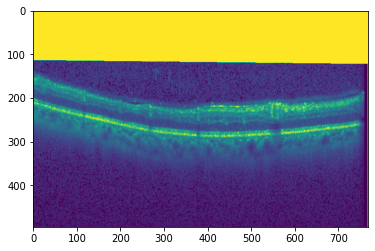

In [ ]:
plt.imshow(img_array[2])

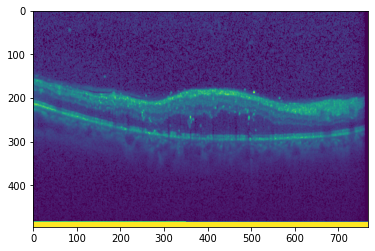

In [ ]:
plt.imshow(img_array[17])

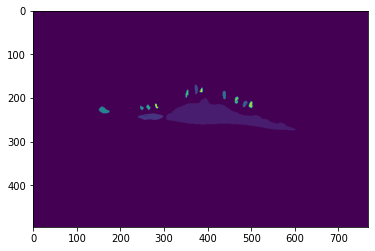

In [ ]:
plt.imshow(manual_fluid_array[25])

In [ ]:
data_indexes = [10, 15, 20, 25, 28, 30, 32, 35, 40, 45, 50]

width = 284
height = 284
width_out = 196
height_out = 196

In [ ]:
def thresh(x):
    if x == 0:
        return 0
    else:
        return 1

thresh = np.vectorize(thresh, otypes=[np.float])

def create_dataset(paths):
    x = []
    y = []
    
    for path in tqdm(paths):
        mat = scipy.io.loadmat(path)
        img_tensor = mat['images']
        fluid_tensor = mat['manualFluid1']
        
        img_array = np.transpose(img_tensor, (2, 0 ,1)) / 255
        img_array = resize(img_array, (img_array.shape[0], width, height))
        fluid_array = np.transpose(fluid_tensor, (2, 0 ,1))
        fluid_array = thresh(fluid_array)
        fluid_array  = resize(fluid_array, (fluid_array .shape[0], width_out, height_out))

        for idx in data_indexes:
            x += [np.expand_dims(img_array[idx], 0)]
            y += [np.expand_dims(fluid_array[idx], 0)]
    return np.array(x), np.array(y)

x_train, y_train = create_dataset(subject_path[:9])
# subject_path[:9]->['Subject_01.mat', 'Subject_02.mat', 'Subject_03.mat', 'Subject_04.mat', 'Subject_05.mat', 'Subject_06.mat', 'Subject_07.mat', 'Subject_08.mat', 'Subject_09.mat']
x_val, y_val = create_dataset(subject_path[9:]) #['Subject_10.mat']

100%|██████████| 1/1 [00:08<00:00,  8.43s/it]


In [ ]:
batch_size = 1
epochs = 200
epoch_lapse = 50
threshold = 0.5
sample_size = None

In [ ]:
class UNet(nn.Module):
    def contracting_block(self, in_channels, out_channels, kernel_size=3):
        block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels), #Applies Batch Normalization over a 4D input, we normalize to speed up learning
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                )
        return block
    
    def expansive_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
                    )
            return  block
    
    def final_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding=1),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                    )
            return  block
    
    def __init__(self, in_channel, out_channel):
        super(UNet, self).__init__()
        #Encode
        self.conv_encode1 = self.contracting_block(in_channels=in_channel, out_channels=64)
        self.conv_maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode2 = self.contracting_block(64, 128)
        self.conv_maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode3 = self.contracting_block(128, 256)
        self.conv_maxpool3 = torch.nn.MaxPool2d(kernel_size=2)
        # Bottleneck
        self.bottleneck = torch.nn.Sequential(
                            torch.nn.Conv2d(kernel_size=3, in_channels=256, out_channels=512),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(512),
                            torch.nn.Conv2d(kernel_size=3, in_channels=512, out_channels=512),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(512),
                            torch.nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
                            )
        # Decode
        self.conv_decode3 = self.expansive_block(512, 256, 128)
        self.conv_decode2 = self.expansive_block(256, 128, 64)
        self.final_layer = self.final_block(128, 64, out_channel)
        
    def crop_and_concat(self, upsampled, bypass, crop=False):
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2
            bypass = F.pad(bypass, (-c, -c, -c, -c))
        return torch.cat((upsampled, bypass), 1)
    
    def forward(self, x):
        # Encode
        encode_block1 = self.conv_encode1(x)
        encode_pool1 = self.conv_maxpool1(encode_block1)
        encode_block2 = self.conv_encode2(encode_pool1)
        encode_pool2 = self.conv_maxpool2(encode_block2)
        encode_block3 = self.conv_encode3(encode_pool2)
        encode_pool3 = self.conv_maxpool3(encode_block3)
        # Bottleneck
        bottleneck1 = self.bottleneck(encode_pool3)
        # Decode
        ##print(x.shape, encode_block1.shape, encode_block2.shape, encode_block3.shape, bottleneck1.shape)
        ##print('Decode Block 3')
        ##print(bottleneck1.shape, encode_block3.shape)
        decode_block3 = self.crop_and_concat(bottleneck1, encode_block3, crop=True)
        ##print(decode_block3.shape)
        ##print('Decode Block 2')
        cat_layer2 = self.conv_decode3(decode_block3)
        ##print(cat_layer2.shape, encode_block2.shape)
        decode_block2 = self.crop_and_concat(cat_layer2, encode_block2, crop=True)
        cat_layer1 = self.conv_decode2(decode_block2)
        ##print(cat_layer1.shape, encode_block1.shape)
        ##print('Final Layer')
        ##print(cat_layer1.shape, encode_block1.shape)
        decode_block1 = self.crop_and_concat(cat_layer1, encode_block1, crop=True)
        ##print(decode_block1.shape)
        final_layer = self.final_layer(decode_block1)
        ##print(final_layer.shape)
        return  final_layer

In [ ]:
def train_step(inputs, labels, optimizer, criterion):
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = unet(inputs)
    # outputs.shape =(batch_size, n_classes, img_cols, img_rows) 
    outputs = outputs.permute(0, 2, 3, 1)
    # outputs.shape =(batch_size, img_cols, img_rows, n_classes) 
    outputs = outputs.resize(batch_size*width_out*height_out, 2)
    labels = labels.resize(batch_size*width_out*height_out)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    return loss

In [ ]:
learning_rate = 0.001
unet = UNet(in_channel=1,out_channel=2)
if use_gpu: #if use_gpu=True
    unet = unet.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(unet.parameters(), lr = 0.01, momentum=0.99)

In [ ]:
def get_val_loss(x_val, y_val):
    x_val = torch.from_numpy(x_val).float()
    y_val = torch.from_numpy(y_val).long()
    if use_gpu:
        x_val = x_val.cuda()
        y_val = y_val.cuda()
    m = x_val.shape[0]
    outputs = unet(x_val)
    # outputs.shape =(batch_size, n_classes, img_cols, img_rows) 
    outputs = outputs.permute(0, 2, 3, 1)
    # outputs.shape =(batch_size, img_cols, img_rows, n_classes) 
    outputs = outputs.resize(m*width_out*height_out, 2)
    labels = y_val.resize(m*width_out*height_out)
    loss = F.cross_entropy(outputs, labels)
    return loss.data

In [ ]:
epoch_iter = np.ceil(x_train.shape[0] / batch_size).astype(int)
t = trange(epochs, leave=True)
for _ in t:
    total_loss = 0
    for i in range(epoch_iter):
        batch_train_x = torch.from_numpy(x_train[i * batch_size : (i + 1) * batch_size]).float()
        batch_train_y = torch.from_numpy(y_train[i * batch_size : (i + 1) * batch_size]).long()
        if use_gpu:
            batch_train_x = batch_train_x.cuda()
            batch_train_y = batch_train_y.cuda()
        batch_loss = train_step(batch_train_x , batch_train_y, optimizer, criterion)
        total_loss += batch_loss
    if (_+1) % epoch_lapse == 0:
        val_loss = get_val_loss(x_val, y_val)
        print(f"Total loss in epoch {_+1} : {total_loss / epoch_iter} and validation loss : {val_loss}")

  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/tensor.py:358: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
 25%|██▌       | 50/200 [12:02<36:30, 14.61s/it]

Total loss in epoch 50 : 2.3375205993652344 and validation loss : 3.2850868701934814


 50%|█████     | 100/200 [24:04<24:20, 14.60s/it]

Total loss in epoch 100 : 2.345118761062622 and validation loss : 3.296473979949951


 75%|███████▌  | 150/200 [36:06<12:09, 14.60s/it]

Total loss in epoch 150 : 2.343381881713867 and validation loss : 3.305494785308838


100%|██████████| 200/200 [48:08<00:00, 14.44s/it]

Total loss in epoch 200 : 2.335930109024048 and validation loss : 3.3074073791503906


In [ ]:
gc.collect()

0

In [ ]:
def plot_examples(datax, datay, num_examples=3):
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(18,4*num_examples))
    m = datax.shape[0]
    for row_num in range(num_examples):
        image_indx = np.random.randint(m)
        image_arr = unet(torch.from_numpy(datax[image_indx:image_indx+1]).float().cuda()).squeeze(0).detach().cpu().numpy()
        ax[row_num][0].imshow(np.transpose(datax[image_indx], (1,2,0))[:,:,0])
        ax[row_num][0].set_title("Original Image")
        ax[row_num][1].imshow(np.transpose(image_arr, (1,2,0))[:,:,0])
        ax[row_num][1].set_title("Segmented Image")
        ax[row_num][2].imshow(image_arr.argmax(0))
        ax[row_num][2].set_title("Segmented Image localization")
        ax[row_num][3].imshow(np.transpose(datay[image_indx], (1,2,0))[:,:,0])
        ax[row_num][3].set_title("Target image")
    plt.show()


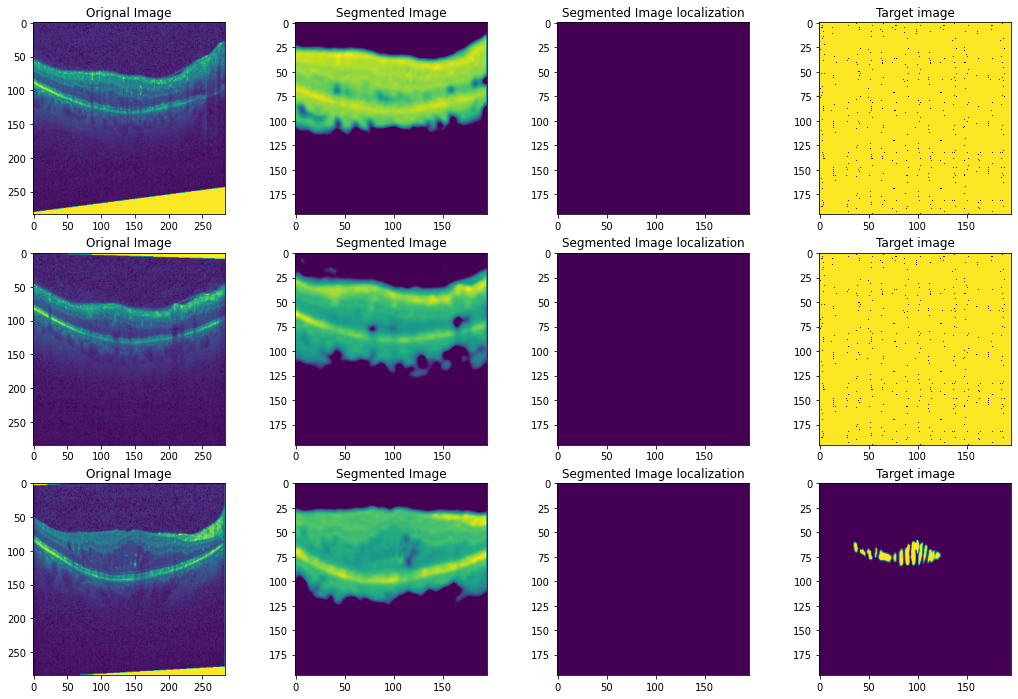

In [ ]:
plot_examples(x_train, y_train)

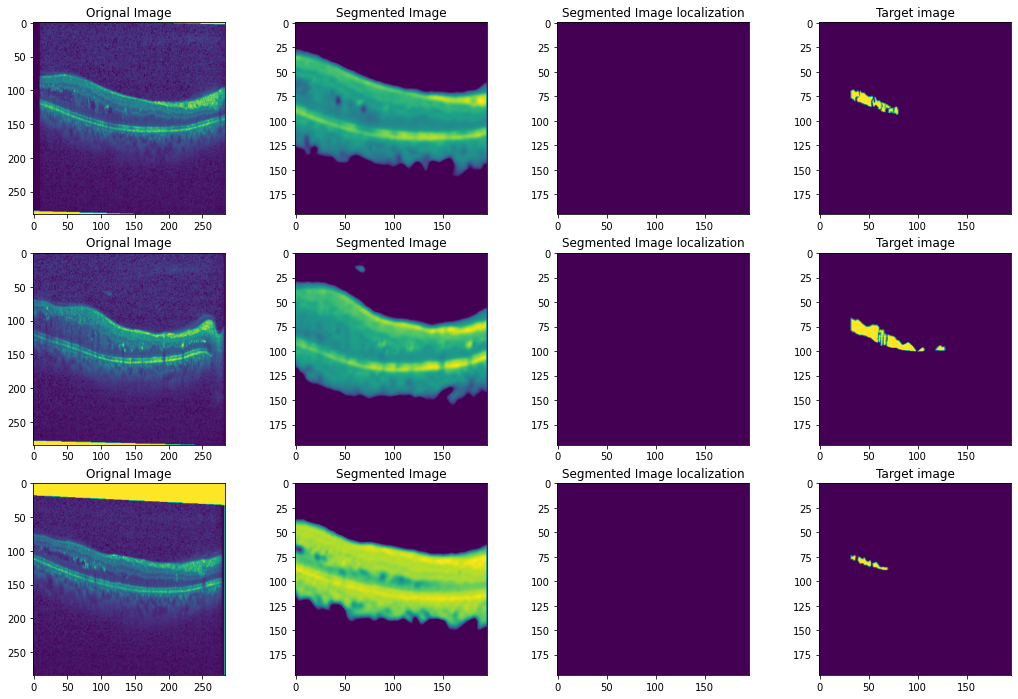

In [ ]:
plot_examples(x_val, y_val)

In [ ]:
torch.save(unet.state_dict(), 'unet.pt')